# Heterogeneous Autoregressive model

The HAR model assumes that the volatility (or other financial variables) is driven by components at different time scales (long-term, medium-term, and short-term).

$$
lnRV_{t+1} = \beta_0 + \beta_1 lnRV_t + \beta_2 lnRV^w_t + \beta_3 lnRV^m_t + \epsilon_t
$$
Where:
- $lnRV_{t+1}$ is the one day ahead forecast of log realised volatility of return.
- $\beta_0, \beta_1, \beta_2, \beta_3$ are the parameters to be estimated.
- $lnRV^w_t$ is the weekly realised variance.
- $lnRV^m_t$ is the monthly realised variance.
- $\epsilon_t$ is the error term.

Flow:
- Load data
- For each lags choice: 

    - Create lags

    - For each forecast horizon: 

        - Split feature and target

        - Split train and test

### Load Data

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [62]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.rename(columns={'timestamp': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df = df.loc[:, ['lnRV']]
df.head(3)

,lnRV
Date,
2019-06-23,-3.865058
2019-06-24,-3.652501
2019-06-25,-3.161881


### Create Lags

In [63]:
def create_lags(df, lags):
    df_copy = df.copy()
    for lag in lags:
        df_copy[f'lnRV_{lag}D_mean_lag'] = df_copy['lnRV'].rolling(window=lag).mean().shift(1)
    df_copy.dropna(inplace=True)
    return df_copy

### Feature & Target Split

In [64]:
def split_f_t(df, lags):
    df_h = create_lags(df, lags)
    
    features = df_h.columns
    features = features[features != 'lnRV']

    X = df_h[features]
    y = df_h['lnRV']
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    return X, y

### Train & Test Split

In [65]:
# Split the data into training and testing sets by the cutoff date
def split_t_t(X, y, cutoff_date='2024-01-01'):
    X_train, X_test = X[X.index < cutoff_date], X[X.index >= cutoff_date]
    y_train, y_test = y[y.index < cutoff_date], y[y.index >= cutoff_date]
    return X_train, X_test, y_train, y_test

### Prediction

In [66]:
cutoff_dates = {1: '2024-01-02', 3: '2024-01-04', 7: '2024-01-08', 30: '2024-01-31'}

In [67]:
def get_pred(df, lags, h):

    # Split the data into features and target
    X, y = split_f_t(df, lags)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = split_t_t(X, y, cutoff_dates[h])
    
    # Fit the model
    model = sm.OLS(y_train, X_train).fit()

    # Make predictions
    pred = model.predict(X_test)
    pred = pd.DataFrame(pred, columns=['Pred'])
    pred.index = X_test.index

    # save predictions to csv
    pred.to_csv(f'../res/HAR{lags}_{h}D.csv')
    
    return pred, y_test

### Plotting

In [68]:
def plot_pred(pred, actual, h, lags):
    plt.figure(figsize=(8, 3))
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.xticks(actual.index[::100])
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(f'HAR{lags}_{h}D-Ahead Forecast')
    plt.legend()
    plt.savefig(f'../res/HAR{lags}_{h}D-Ahead Forecast.png')

## Results

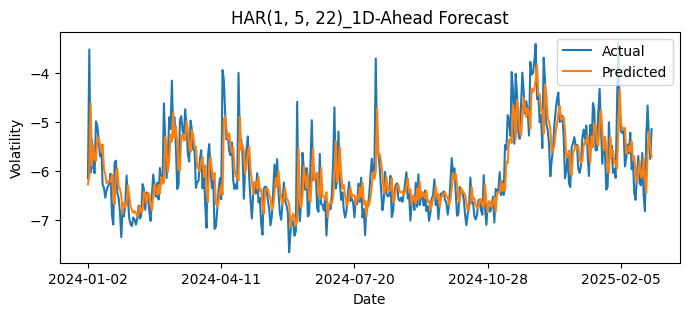

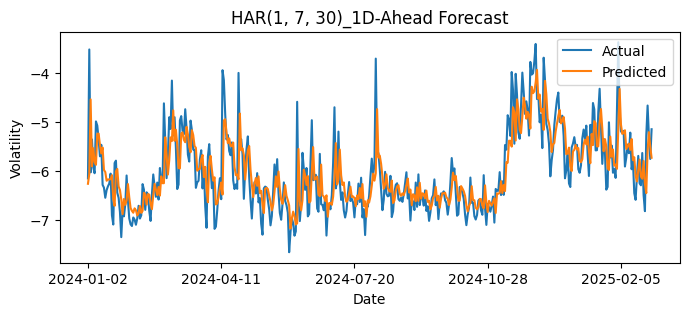

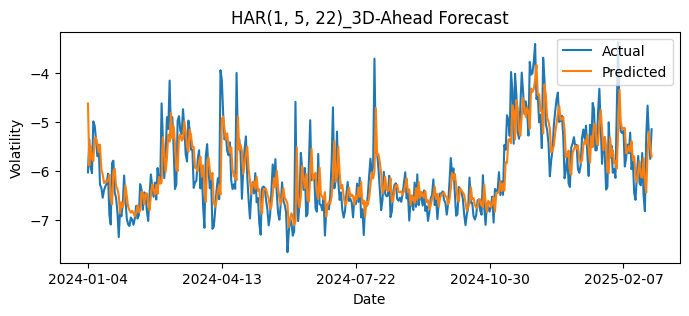

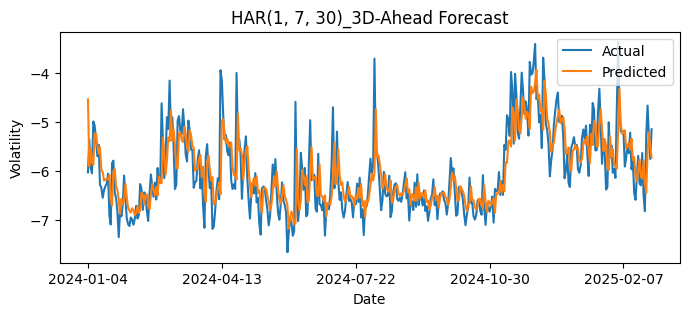

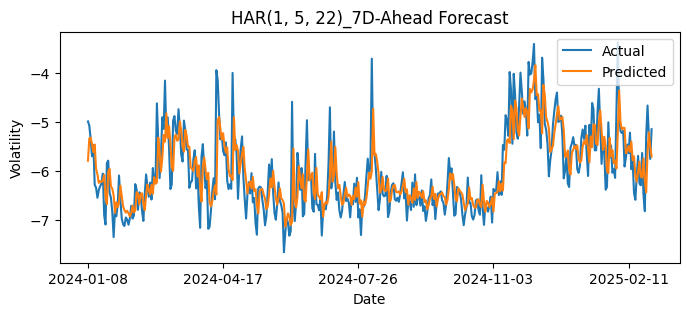

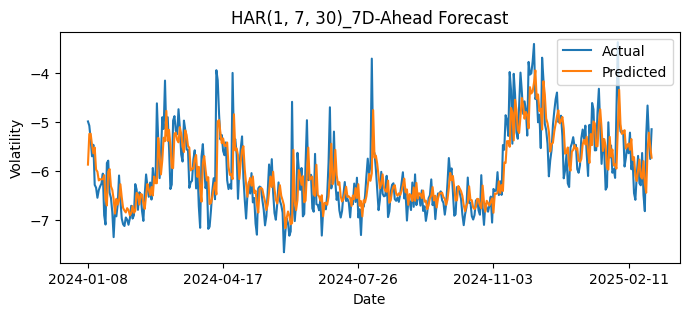

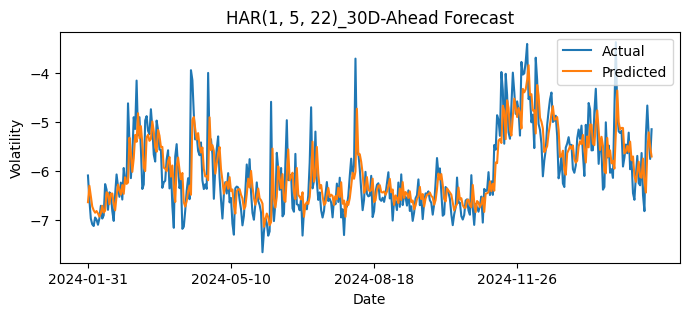

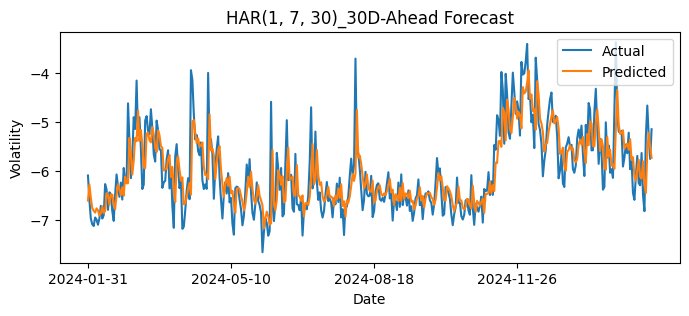

In [69]:
for h in [1, 3, 7, 30]:
    for lags in ((1,5,22), (1,7,30)):
        pred, actual = get_pred(df, lags, h)
        plot_pred(pred, actual, h, lags)